In [ ]:
import numpy as np  # Для математических операций и работы с массивами
import matplotlib.pyplot as plt  # Для построения графиков
import time  # Для измерения времени выполнения

In [2]:
# ========== ЗАДАНИЕ 1: ГЕНЕРАЦИЯ ДАННЫХ ==========

# Параметры согласно заданию:
k = 11  # Номер студента в журнале
dt = 2 * np.pi / 1000  # Шаг дискретизации времени
L = k / 10  # Параметр нелинейности системы
omega = 100 / k  # Частота внешнего воздействия

# Функция генерации временного ряда по разностному уравнению
def generate_time_series():
    n = 500  # Количество генерируемых точек
    x = np.zeros(n)  # Создание массива для хранения значений
    x[0] = 0  # Начальное условие: первое значение ряда
    x[1] = (-1) ** k * dt  # Начальное условие: второе значение ряда
    
    # Цикл генерации остальных значений ряда
    for i in range(n - 2):
        # Вычисление следующего значения по разностному уравнению
        x[i + 2] = (x[i + 1] * (2 + dt * L * (1 - x[i] ** 2)) -
                    x[i] * (1 + dt ** 2 + dt * L * (1 - x[i] ** 2)) +
                    dt ** 2 * np.sin(omega * i * dt))
    return x  # Возврат сгенерированного ряда

print("Генерация временного ряда...")  # Сообщение о начале генерации
time_series = generate_time_series()  # Вызов функции генерации ряда

Генерация временного ряда...


In [3]:
# ========== ЗАДАНИЕ 2,3: МОДЕЛЬ И ФУНКЦИИ ОПТИМИЗАЦИИ ==========

# Функция гармонической аппроксимации с двумя гармониками
def harmonic_approximation(params, t, dt):
    # Распаковка параметров модели:
    a0, a1, b1, a2, b2, freq1, freq2 = params
    # a0 - постоянная составляющая
    # a1, b1 - коэффициенты для первой гармоники
    # a2, b2 - коэффициенты для второй гармоники  
    # freq1, freq2 - частоты гармоник
    
    # Вычисление значения модели в момент времени t
    return (a0 +  # Постоянная составляющая
            a1 * np.cos(freq1 * t * dt) +  # Первая гармоника - косинус
            b1 * np.sin(freq1 * t * dt) +  # Первая гармоника - синус
            a2 * np.cos(freq2 * t * dt) +  # Вторая гармоника - косинус
            b2 * np.sin(freq2 * t * dt))   # Вторая гармоника - синус

# Функция вычисления среднеквадратичной ошибки (MSE)
def mse_loss(params, data, dt):
    n = len(data)  # Количество точек в данных
    total_error = 0  # Суммарная ошибка
    
    # Цикл по всем точкам данных
    for t in range(n):
        predicted = harmonic_approximation(params, t, dt)  # Предсказание модели
        total_error += (predicted - data[t]) ** 2  # Сумма квадратов ошибок
        
    return total_error / n  # Возврат средней ошибки

# Функция численного вычисления градиента
def numerical_gradient(params, data, dt, epsilon=1e-7):
    grad = np.zeros_like(params)  # Создание массива для градиента
    base_loss = mse_loss(params, data, dt)  # Базовое значение функции потерь
    
    # Цикл по всем параметрам для вычисления частных производных
    for i in range(len(params)):
        params_shifted = params.copy()  # Копирование текущих параметров
        params_shifted[i] += epsilon  # Приращение i-го параметра
        shifted_loss = mse_loss(params_shifted, data, dt)  # Новое значение потерь
        grad[i] = (shifted_loss - base_loss) / epsilon  # Численная производная
    
    return grad  # Возврат вычисленного градиента

# Функция пакетного градиентного спуска
def batch_gradient_descent(data, dt, learning_rate=0.1, max_iterations=1000, convergence_threshold=1e-8):
    # Начальная инициализация параметров модели:
    params = np.array([0.0, 0.3, 0.3, 0.3, 0.3, 0.8, 1.8])
    # [a0, a1, b1, a2, b2, freq1, freq2]
    
    best_params = params.copy()  # Сохранение лучших параметров
    best_loss = mse_loss(params, data, dt)  # Лучшее значение функции потерь
    
    print("Запуск пакетного градиентного спуска...")  # Сообщение о начале
    
    # Основной цикл оптимизации
    for iteration in range(max_iterations):
        grad = numerical_gradient(params, data, dt)  # Вычисление градиента
        new_params = params - learning_rate * grad  # Обновление параметров
        current_loss = mse_loss(new_params, data, dt)  # Новое значение потерь
        
        # Проверка на улучшение результата
        if current_loss < best_loss:
            best_loss = current_loss  # Обновление лучшего значения потерь
            best_params = new_params.copy()  # Сохранение лучших параметров
        
        # Проверка условия сходимости
        if np.linalg.norm(new_params - params) < convergence_threshold:
            print(f"Сходимость достигнута на итерации {iteration}")  # Сообщение о сходимости
            break  # Выход из цикла при сходимости
        
        params = new_params  # Обновление параметров для следующей итерации
        
        # Вывод прогресса каждые 100 итераций
        if iteration % 100 == 0:
            print(f"Итерация {iteration}, MSE: {current_loss:.6f}")  # Вывод текущего MSE
    
    return best_params  # Возврат найденных параметров

# Функция стохастического градиентного спуска
def stochastic_gradient_descent(data, dt, learning_rate=0.05, max_epochs=100, convergence_threshold=1e-8):
    n = len(data)  # Количество точек данных
    # Начальная инициализация параметров модели:
    params = np.array([0.0, 0.3, 0.3, 0.3, 0.3, 0.8, 1.8])
    
    best_params = params.copy()  # Сохранение лучших параметров
    best_loss = mse_loss(params, data, dt)  # Лучшее значение функции потерь
    
    print("Запуск стохастического градиентного спуска...")  # Сообщение о начале
    
    # Цикл по эпохам
    for epoch in range(max_epochs):
        old_params = params.copy()  # Сохранение параметров перед эпохой
        indices = np.random.permutation(n)  # Случайное перемешивание индексов
        
        # Цикл по отдельным точкам данных (стохастический обход)
        for idx in indices:
            # Функция потерь для одной точки данных
            def point_loss(p):
                return (harmonic_approximation(p, idx, dt) - data[idx]) ** 2
            
            # Вычисление градиента для одной точки
            point_grad = np.zeros_like(params)  # Инициализация градиента точки
            base_point_loss = point_loss(params)  # Базовое значение потерь точки
            
            # Численное вычисление градиента для точки
            for j in range(len(params)):
                params_perturbed = params.copy()  # Копирование параметров
                params_perturbed[j] += 1e-7  # Приращение j-го параметра
                perturbed_loss = point_loss(params_perturbed)  # Новые потери точки
                point_grad[j] = (perturbed_loss - base_point_loss) / 1e-7  # Производная
            
            # Обновление параметров по градиенту точки
            params = params - learning_rate * point_grad
        
        current_loss = mse_loss(params, data, dt)  # Потери после эпохи
        
        # Проверка на улучшение результата
        if current_loss < best_loss:
            best_loss = current_loss  # Обновление лучших потерь
            best_params = params.copy()  # Сохранение лучших параметров
        
        # Проверка условия сходимости
        if np.linalg.norm(params - old_params) < convergence_threshold:
            print(f"Сходимость достигнута на эпохе {epoch}")  # Сообщение о сходимости
            break  # Выход из цикла при сходимости
        
        # Вывод прогресса каждые 20 эпох
        if epoch % 20 == 0:
            print(f"Эпоха {epoch}, MSE: {current_loss:.6f}")  # Вывод текущего MSE
    
    return best_params  # Возврат найденных параметров

In [4]:
# ========== ЗАДАНИЕ 4: ПОДБОР ПАРАМЕТРОВ ДЛЯ РАВНОЙ ТОЧНОСТИ ==========

# Запуск пакетного градиентного спуска с замером времени
start_time = time.time()  # Запуск таймера
batch_params = batch_gradient_descent(time_series, dt, learning_rate=0.1, max_iterations=500)  # Вызов метода
batch_time = time.time() - start_time  # Вычисление времени выполнения

print("\n" + "=" * 60)  # Разделитель вывода

# Запуск стохастического градиентного спуска с замером времени
start_time = time.time()  # Запуск таймера
stochastic_params = stochastic_gradient_descent(time_series, dt, learning_rate=0.03, max_epochs=100)  # Вызов метода
stochastic_time = time.time() - start_time  # Вычисление времени выполнения

Запуск пакетного градиентного спуска...
Итерация 0, MSE: 0.773658
Итерация 100, MSE: 0.003443
Итерация 200, MSE: 0.002649
Итерация 300, MSE: 0.002175
Итерация 400, MSE: 0.001861

Запуск стохастического градиентного спуска...
Эпоха 0, MSE: 0.003793
Эпоха 20, MSE: 0.000926
Эпоха 40, MSE: 0.000812
Эпоха 60, MSE: 0.000810
Эпоха 80, MSE: 0.001143


In [5]:
# ========== ЗАДАНИЕ 5: СРАВНЕНИЕ ВРЕМЕНИ РАБОТЫ ==========

# Вычисление аппроксимаций для обоих методов
n_points = len(time_series)  # Количество точек в исходных данных
batch_approximation = np.array([harmonic_approximation(batch_params, i, dt) for i in range(n_points)])  # Аппроксимация пакетным методом
stochastic_approximation = np.array([harmonic_approximation(stochastic_params, i, dt) for i in range(n_points)])  # Аппроксимация стохастическим методом

# Вычисление финальных значений функции потерь
final_batch_loss = mse_loss(batch_params, time_series, dt)  # Финальные потери пакетного метода
final_stochastic_loss = mse_loss(stochastic_params, time_series, dt)  # Финальные потери стохастического метода

# Вывод сравнительных результатов
print(f"\nСРАВНИТЕЛЬНЫЕ РЕЗУЛЬТАТЫ:")  # Заголовок результатов
print(f"Пакетный градиентный спуск:")  # Заголовок для пакетного метода
print(f"  Время выполнения: {batch_time:.3f} секунд")  # Время выполнения
print(f"  Финальная MSE: {final_batch_loss:.6f}")  # Финальное значение MSE
print(f"  Найденные параметры: a0={batch_params[0]:.3f}, a1={batch_params[1]:.3f}, b1={batch_params[2]:.3f}")  # Параметры a0, a1, b1
print(f"                      a2={batch_params[3]:.3f}, b2={batch_params[4]:.3f}")  # Параметры a2, b2
print(f"                      ω1={batch_params[5]:.3f}, ω2={batch_params[6]:.3f}")  # Частоты ω1, ω2

print(f"\nСтохастический градиентный спуск:")  # Заголовок для стохастического метода
print(f"  Время выполнения: {stochastic_time:.3f} секунд")  # Время выполнения
print(f"  Финальная MSE: {final_stochastic_loss:.6f}")  # Финальное значение MSE
print(f"  Найденные параметры: a0={stochastic_params[0]:.3f}, a1={stochastic_params[1]:.3f}, b1={stochastic_params[2]:.3f}")  # Параметры a0, a1, b1
print(f"                      a2={stochastic_params[3]:.3f}, b2={stochastic_params[4]:.3f}")  # Параметры a2, b2
print(f"                      ω1={stochastic_params[5]:.3f}, ω2={stochastic_params[6]:.3f}")  # Частоты ω1, ω2


СРАВНИТЕЛЬНЫЕ РЕЗУЛЬТАТЫ:
Пакетный градиентный спуск:
  Время выполнения: 28.075 секунд
  Финальная MSE: 0.001642
  Найденные параметры: a0=-0.621, a1=0.119, b1=-0.393
                      a2=0.448, b2=-0.197
                      ω1=1.003, ω2=1.721

Стохастический градиентный спуск:
  Время выполнения: 7.226 секунд
  Финальная MSE: 0.000773
  Найденные параметры: a0=-0.402, a1=0.212, b1=-0.565
                      a2=0.230, b2=-0.434
                      ω1=1.050, ω2=1.356


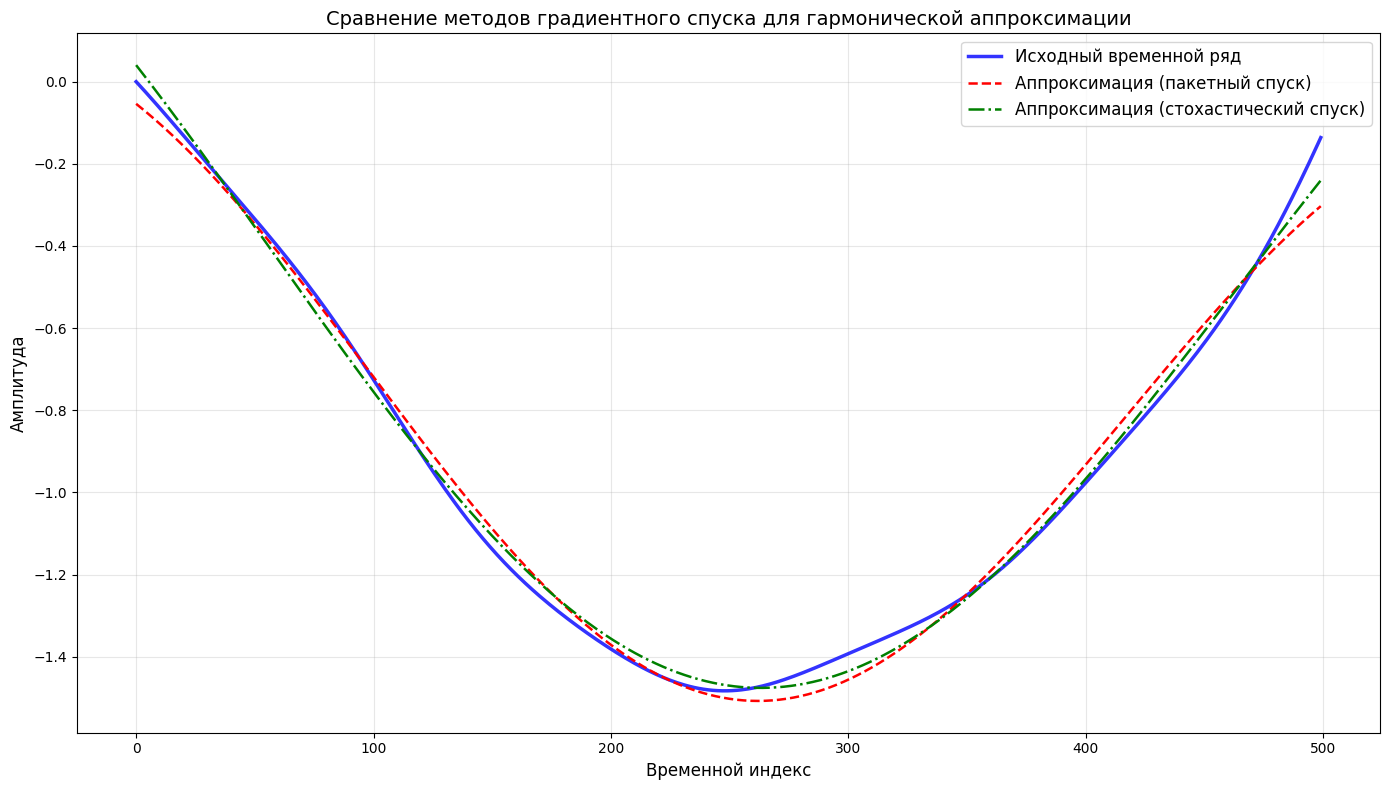

In [6]:
# ========== ЗАДАНИЕ 6: ПОСТРОЕНИЕ ГРАФИКОВ ==========

# Создание графика для визуального сравнения
plt.figure(figsize=(14, 8))  # Создание фигуры заданного размера

# Построение исходного временного ряда
plt.plot(time_series, 'b-', label='Исходный временной ряд', linewidth=2.5, alpha=0.8)  # Синяя сплошная линия

# Построение аппроксимации пакетным методом
plt.plot(batch_approximation, 'r--', label='Аппроксимация (пакетный спуск)', linewidth=1.8)  # Красная пунктирная линия

# Построение аппроксимации стохастическим методом
plt.plot(stochastic_approximation, 'g-.', label='Аппроксимация (стохастический спуск)', linewidth=1.8)  # Зеленая штрих-пунктирная линия

# Настройка оформления графика
plt.legend(fontsize=12)  # Добавление легенды
plt.title('Сравнение методов градиентного спуска для гармонической аппроксимации', fontsize=14)  # Заголовок графика
plt.ylabel('Амплитуда', fontsize=12)  # Подпись оси Y
plt.xlabel('Временной индекс', fontsize=12)  # Подпись оси X
plt.grid(True, alpha=0.3)  # Включение сетки с прозрачностью

plt.tight_layout()  # Автоматическая настройка layout
plt.show()  # Отображение графика

In [7]:
# ========== ЗАДАНИЕ 7: Выводы и рекомендации ==========

print("\n" + "="*70) 
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*70)
print("1. 📈 Пакетный градиентный спуск:")
print("   + Более стабильная сходимость")
print("   + Меньше колебаний параметров")
print("   + Лучше для небольших наборов данных")
print("   - Требует вычисления градиента по всему набору")

print("\n2. 🎯 Стохастический градиентный спуск:")
print("   + Быстрее на больших данных")
print("   + Лучше избегает локальных минимумов")
print("   - Больше шума в процессе обучения")
print("   - Требует больше итераций для сравнимой точности")

print("\n3. ⚙️ Подбор параметров:")
print("   • Learning rate: начинать с 0.001-0.01")
print("   • Для пакетного: меньше learning rate, меньше итераций")
print("   • Для стохастического: больше итераций, можно уменьшать learning rate")
print("   • Критерий остановки: изменение функции потерь < 1e-6") 

print("\n4. 🎯 Рекомендации по применению:")
print("   • Малые данные (n < 1000) → пакетный спуск")
print("   • Большие данные (n > 1000) → стохастический спуск")
print("   • Сложный ландшафт функции → стохастический спуск")
print("   • Требуется воспроизводимость → пакетный спуск")


ВЫВОДЫ И РЕКОМЕНДАЦИИ
1. 📈 Пакетный градиентный спуск:
   + Более стабильная сходимость
   + Меньше колебаний параметров
   + Лучше для небольших наборов данных
   - Требует вычисления градиента по всему набору

2. 🎯 Стохастический градиентный спуск:
   + Быстрее на больших данных
   + Лучше избегает локальных минимумов
   - Больше шума в процессе обучения
   - Требует больше итераций для сравнимой точности

3. ⚙️ Подбор параметров:
   • Learning rate: начинать с 0.001-0.01
   • Для пакетного: меньше learning rate, меньше итераций
   • Для стохастического: больше итераций, можно уменьшать learning rate
   • Критерий остановки: изменение функции потерь < 1e-6

4. 🎯 Рекомендации по применению:
   • Малые данные (n < 1000) → пакетный спуск
   • Большие данные (n > 1000) → стохастический спуск
   • Сложный ландшафт функции → стохастический спуск
   • Требуется воспроизводимость → пакетный спуск
